In [1]:
import torch
import torch.nn as nn

In [2]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d*2, 4, 2, 1),
            self._block(features_d*2, features_d*4, 4, 2, 1),
            self._block(features_d*4, features_d*8, 4, 2, 1),
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )
    
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.disc(x)

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential (
            self._block(z_dim, features_g*16, 4, 1, 0),
            self._block(features_g*16, features_g*8, 4, 2, 1),
            self._block(features_g*8, features_g*4, 4, 2, 1),
            self._block(features_g*4, features_g*2, 4, 2, 1),
            nn.ConvTranspose2d(features_g*2, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )
    
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.gen(x)


In [4]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [5]:
def test():
    N, in_channels, H, W = 8, 3, 64, 64
    z_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    initialize_weights(disc)
    assert disc(x).shape == (N, 1, 1, 1)
    gen = Generator(z_dim, in_channels, 8)
    initialize_weights(gen)
    z = torch.randn((N, z_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W)
    print("Success")

In [6]:
test()

Success


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
print(device)

cuda:0


In [9]:
LEARNING_RATE = 2e-4
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 5
FEATURES_DISC = 64
FEATURES_GEN = 64

In [10]:
from torchvision import transforms

In [11]:
transform = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]),
    ]
)

In [12]:
import torchvision

In [13]:
mnist = torchvision.datasets.MNIST(root='datasets/',
                                   train=True,
                                   transform=transform,
                                   download=True)

In [14]:
from torch.utils.data import DataLoader

In [15]:
data_loader = DataLoader(dataset=mnist, batch_size=BATCH_SIZE, shuffle=True)

In [16]:
images, labels = iter(data_loader).next()

In [17]:
images

tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., 

In [18]:
labels

tensor([9, 6, 5, 7, 3, 4, 4, 0, 9, 5, 1, 0, 2, 9, 5, 8, 6, 2, 4, 6, 3, 0, 9, 9,
        6, 4, 7, 5, 9, 6, 3, 8, 0, 6, 2, 4, 7, 9, 8, 6, 6, 0, 2, 0, 6, 1, 5, 8,
        3, 6, 9, 7, 6, 8, 2, 7, 3, 5, 1, 1, 7, 2, 8, 6, 5, 9, 7, 3, 2, 3, 5, 7,
        5, 4, 1, 2, 3, 8, 2, 0, 6, 3, 1, 1, 5, 8, 2, 0, 4, 5, 9, 9, 1, 8, 2, 1,
        4, 2, 8, 6, 4, 8, 2, 3, 8, 0, 3, 4, 2, 9, 0, 8, 1, 3, 1, 4, 9, 1, 6, 7,
        9, 0, 9, 3, 6, 2, 2, 4])

In [19]:
import matplotlib.pyplot as plt
import numpy as np

In [20]:
img = torchvision.utils.make_grid(images)

In [21]:
img = img.detach().cpu().numpy()
img = img.clip(0,1)

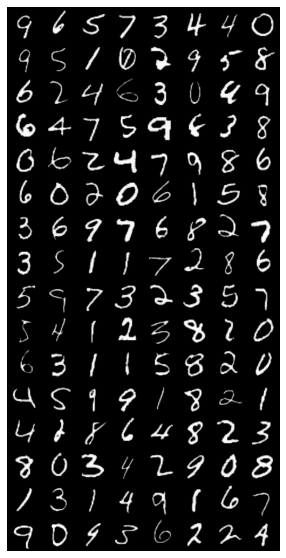

In [22]:
plt.figure(figsize = (12, 10))
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.axis('off')
plt.show()

In [23]:
print("Hi")

Hi


In [24]:
import torch.optim as optim

In [25]:
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

In [26]:
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)

In [27]:
step = 0
gen.train()
disc.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (6): Sigmoid()
  )
)

In [28]:
img_grid_reals = []
img_grid_fakes = []


In [29]:
for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (real, _) in enumerate(data_loader):
        real = real.to(device)
        noise = torch.randn((BATCH_SIZE, Z_DIM, 1, 1)).to(device)
        fake = gen(noise)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(data_loader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(
                    real[:32], normalize=True
                )
                img_grid_fake = torchvision.utils.make_grid(
                    fake[:32], normalize=True
                )
                img_grid_reals.append(img_grid_real)
                img_grid_fakes.append(img_grid_fake)

            

            step += 1

Epoch [0/5] Batch 0/469                   Loss D: 0.6883, loss G: 0.7967
Epoch [0/5] Batch 100/469                   Loss D: 0.0153, loss G: 4.1377
Epoch [0/5] Batch 200/469                   Loss D: 0.4431, loss G: 1.3469
Epoch [0/5] Batch 300/469                   Loss D: 0.5015, loss G: 1.2776
Epoch [0/5] Batch 400/469                   Loss D: 0.4974, loss G: 1.5935
Epoch [1/5] Batch 0/469                   Loss D: 0.5602, loss G: 0.9205
Epoch [1/5] Batch 100/469                   Loss D: 0.6044, loss G: 0.6933
Epoch [1/5] Batch 200/469                   Loss D: 0.7152, loss G: 0.9964
Epoch [1/5] Batch 300/469                   Loss D: 0.5684, loss G: 0.9292
Epoch [1/5] Batch 400/469                   Loss D: 0.5918, loss G: 1.1022
Epoch [2/5] Batch 0/469                   Loss D: 0.4679, loss G: 2.2833
Epoch [2/5] Batch 100/469                   Loss D: 0.3123, loss G: 2.1049
Epoch [2/5] Batch 200/469                   Loss D: 0.2667, loss G: 2.0241
Epoch [2/5] Batch 300/469      

In [35]:
print(len(img_grid_fakes))

25


In [47]:
img = img_grid_fakes[24]

In [48]:
img = img.detach().cpu().numpy()
img = img.clip(0,1)

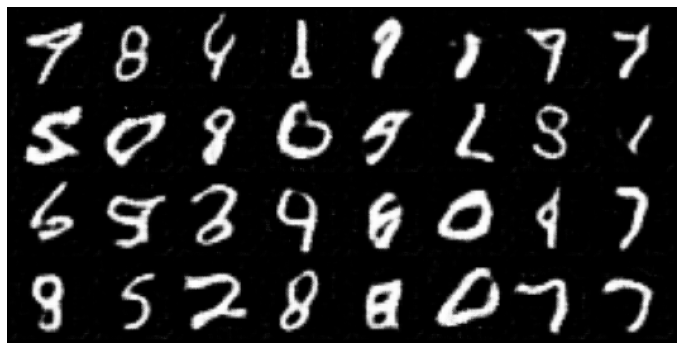

In [49]:
plt.figure(figsize = (12, 10))
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.axis('off')
plt.show()